In [1]:
# Make OurIRS2016byZIP data
#
# Richard Paterson (Tue Evening Class)
#
# Read in IRS2016 agi data
# select zip codes for AZ and NV only
# summarise by zip code
# write out zip code, agi, no returns, average agi to csv
#   NB agi is shown in 000's of dollars
#      average agi is in $
# 

In [2]:
# import packages for analysis and modeling
import pandas as pd #data frame operations
import numpy as np #arrays and math functions
from scipy.stats import uniform #for training and test splits
import statsmodels.api as smf #R-like model specification
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from math import sqrt
import datetime
from pandas import Series
from pandas import DataFrame
from pandas import TimeGrouper
import matplotlib.pyplot as plt #2D plotting
import seaborn as sns
from fbprophet import Prophet

print("Environmental Stuff")
print("===================")

#setup environment
import os
print("Current Working Directory " , os.getcwd())
os.chdir("C:/Users/Richpat/Documents/@syracuse coursework/@IST 718 Big Data Analytics (Python)/finalproject")

# System Information
import platform

print('Python is ' + platform.python_version())

pd.show_versions(as_json=True) # True to shorten output

Environmental Stuff
Current Working Directory  c:\Users\Richpat\Documents\@syracuse coursework\@IST 718 Big Data Analytics (Python)\finalproject
Python is 3.6.7
{'system': {'commit': None, 'python': '3.6.7.final.0', 'python-bits': 64, 'OS': 'Windows', 'OS-release': '10', 'machine': 'AMD64', 'processor': 'Intel64 Family 6 Model 142 Stepping 10, GenuineIntel', 'byteorder': 'little', 'LC_ALL': 'None', 'LANG': 'None', 'LOCALE': 'None.None'}, 'dependencies': {'pandas': '0.24.2', 'pytest': '4.4.1', 'pip': '19.1', 'setuptools': '41.0.1', 'Cython': '0.29.7', 'numpy': '1.16.3', 'scipy': '1.2.1', 'pyarrow': None, 'xarray': None, 'IPython': '7.5.0', 'sphinx': '2.0.1', 'patsy': '0.5.1', 'dateutil': '2.8.0', 'pytz': '2019.1', 'blosc': None, 'bottleneck': None, 'tables': None, 'numexpr': None, 'feather': None, 'matplotlib': '3.0.3', 'openpyxl': '2.6.1', 'xlrd': '1.2.0', 'xlwt': '1.3.0', 'xlsxwriter': '1.1.7', 'lxml.etree': '4.3.3', 'bs4': '4.7.1', 'html5lib': '1.0.1', 'sqlalchemy': '1.3.2', 'pymysql

In [3]:
def descriptiveStatsNum(vals, key, title, verbose):
    x_plot=vals
    
    print ("Data Sample for ", title)
    print(pd.DataFrame.head(x_plot))
    
    ax = sns.distplot(x_plot)
    ax.axvline(x_plot.median(), lw=2.5, ls='dashed', color='black')
    ax.axvline(x_plot.mean(), lw=2.5, ls='dashed', color='red')
    plt.title(title + ' Distribution with Median (black) and Mean (red)')
    plt.show()

    print (title +' Descriptive Stats for ' + key)
    print (x_plot.describe())

    ax = sns.boxplot(x_plot, orient='v')
    plt.title(title + ' Boxplot')
    plt.show()
    
    return

In [4]:
# read in IRS 2016 data and create data frame including adjusted gross income (AGI) and total returns

agi2016raw = pd.read_csv("16zpallnoagi.csv", sep=",", encoding = 'utf-8')

print("agi2016raw data")
print("================")

#print("\n***** isna")
#print(agi2016raw.isnull().sum())

print("\n***** dtypes")
print(agi2016raw.dtypes)

print("\n***** head")
print(pd.DataFrame.head(agi2016raw))

print("\n***** describe")
print(agi2016raw.describe())

agi2016raw data

***** dtypes
STATEFIPS      int64
STATE         object
ZIPCODE        int64
AGI_STUB       int64
N1             int64
MARS1          int64
MARS2          int64
MARS4          int64
PREP           int64
N2             int64
NUMDEP         int64
TOTAL_VITA     int64
VITA           int64
TCE            int64
VITA_EIC       int64
RAL            int64
RAC            int64
ELDERLY        int64
A00100         int64
N02650         int64
A02650         int64
N00200         int64
A00200         int64
N00300         int64
A00300         int64
N00600         int64
A00600         int64
N00650         int64
A00650         int64
N00700         int64
               ...  
N85770         int64
A85770         int64
N85775         int64
A85775         int64
N09750         int64
A09750         int64
N10600         int64
A10600         int64
N59660         int64
A59660         int64
N59720         int64
A59720         int64
N11070         int64
A11070         int64
N10960         int64
A109

In [5]:
#summarise the IRS2016 data b yzipecode, writing out agi and no returns

agi2016raw = agi2016raw[(agi2016raw.ZIPCODE>0)&(agi2016raw.ZIPCODE<99999)]
agi2016byzip = agi2016raw[((agi2016raw.STATE=='NV')|(agi2016raw.STATE=='AZ'))].groupby(['STATE', 'ZIPCODE'])['A00100', 'N1'].agg(['sum'])
agi2016byzip.columns = ['AGI2016', 'NoReturns']
agi2016byzip["AvgAGI2016"] = (agi2016byzip['AGI2016'] / agi2016byzip['NoReturns'] * 1000).round(0) #avg AGI in $ terms

print("agi2016byzip data : length:", len(agi2016byzip))
print("==================================")

print("\n***** describe")
print(agi2016byzip.describe())

print("\n***** head")
print(pd.DataFrame.head(agi2016byzip))


agi2016byzip data : length: 534

***** describe
            AGI2016     NoReturns     AvgAGI2016
count  5.340000e+02    534.000000     534.000000
mean   4.960840e+05   7793.220974   60839.503745
std    6.031326e+05   8032.768170   45849.172341
min    3.180000e+03     90.000000   18152.000000
25%    2.787700e+04    670.000000   38728.000000
50%    2.744005e+05   4665.000000   49653.000000
75%    7.755822e+05  14045.000000   67445.250000
max    4.532781e+06  32130.000000  484222.000000

***** head
               AGI2016  NoReturns  AvgAGI2016
STATE ZIPCODE                                
AZ    85003     282886       3900     72535.0
      85004     227527       2960     76867.0
      85006     347753       9680     35925.0
      85007     274046       5300     51707.0
      85008     788776      23140     34087.0


Data Sample for  Adjusted Gross Income
STATE  ZIPCODE
AZ     85003      282886
       85004      227527
       85006      347753
       85007      274046
       85008      788776
Name: AGI2016, dtype: int64


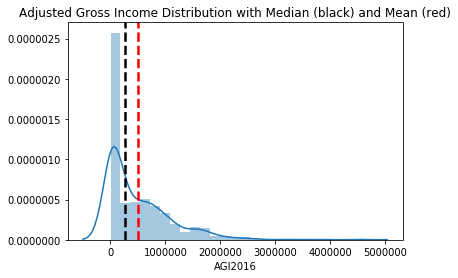

Adjusted Gross Income Descriptive Stats for zip
count    5.340000e+02
mean     4.960840e+05
std      6.031326e+05
min      3.180000e+03
25%      2.787700e+04
50%      2.744005e+05
75%      7.755822e+05
max      4.532781e+06
Name: AGI2016, dtype: float64


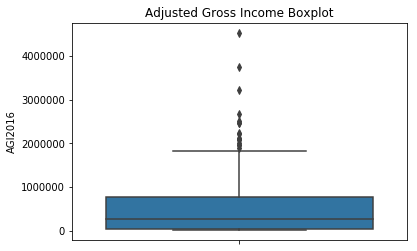

Data Sample for  No Returns
STATE  ZIPCODE
AZ     85003       3900
       85004       2960
       85006       9680
       85007       5300
       85008      23140
Name: NoReturns, dtype: int64


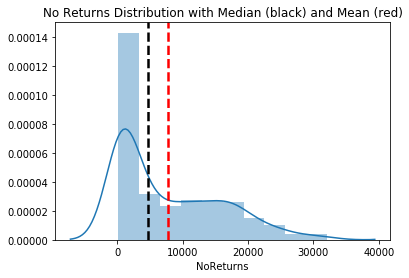

No Returns Descriptive Stats for zip
count      534.000000
mean      7793.220974
std       8032.768170
min         90.000000
25%        670.000000
50%       4665.000000
75%      14045.000000
max      32130.000000
Name: NoReturns, dtype: float64


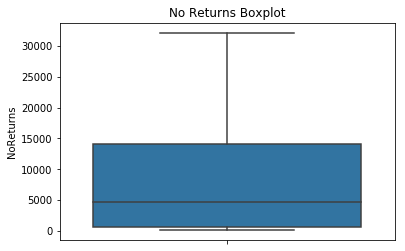

Data Sample for  Average Adjusted Gross Income
STATE  ZIPCODE
AZ     85003      72535.0
       85004      76867.0
       85006      35925.0
       85007      51707.0
       85008      34087.0
Name: AvgAGI2016, dtype: float64


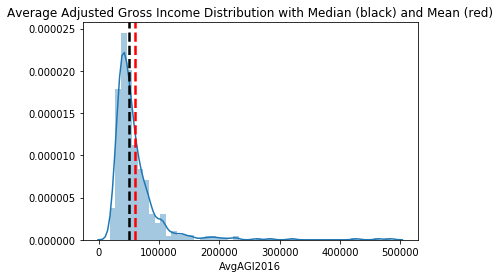

Average Adjusted Gross Income Descriptive Stats for zip
count       534.000000
mean      60839.503745
std       45849.172341
min       18152.000000
25%       38728.000000
50%       49653.000000
75%       67445.250000
max      484222.000000
Name: AvgAGI2016, dtype: float64


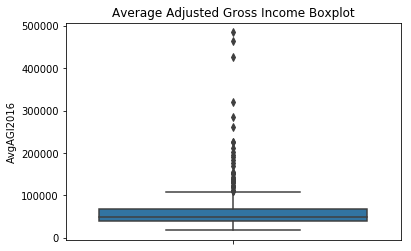

In [6]:
#run descriptive stats across 3 numeric columns

descriptiveStatsNum(agi2016byzip['AGI2016'], 'zip', 'Adjusted Gross Income', 1)

descriptiveStatsNum(agi2016byzip['NoReturns'], 'zip', 'No Returns', 1)

descriptiveStatsNum(agi2016byzip['AvgAGI2016'], 'zip', 'Average Adjusted Gross Income', 1)

In [7]:
#calculate avg AGI
#write data out to csv

#print("\nNumber of Extended Length zips", (i-1))
#write growth to csv; just in case
#print("\nStart of sort", datetime.datetime.now())
#zillowXL=zillowXL.sort_values('FCGrowth', ascending=False)

print("\nStart of write", datetime.datetime.now())
agi2016byzip.to_csv("ourIRS2016byzip.csv", sep=",", encoding = 'utf-8')
print("\nEnd of write", datetime.datetime.now())


Start of write 2019-05-25 16:23:05.583595

End of write 2019-05-25 16:23:05.590617


Average AGI by Zipcode: Top 50   (534, 1)


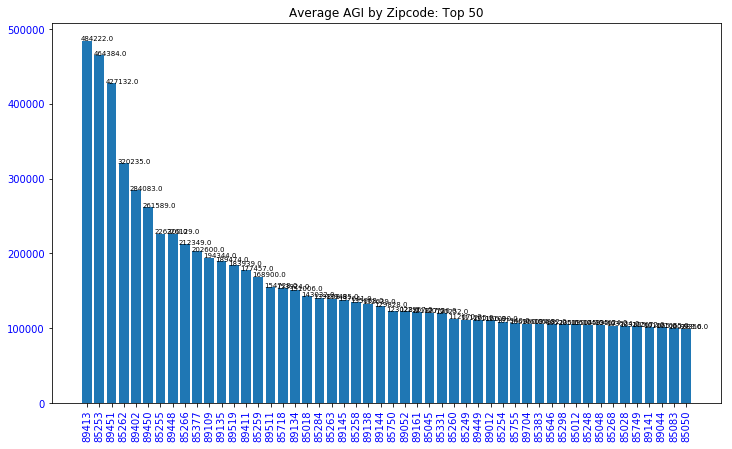

In [8]:
# This routine plots Top n zipcodes by size of Avg AGI

PltMX=pd.DataFrame(agi2016byzip['AvgAGI2016'])
PltMX.index=agi2016byzip.index.get_level_values("ZIPCODE").astype(str)
PltMX=PltMX.sort_values('AvgAGI2016', ascending=False)
PltToShow=50
PltTitle='Average AGI by Zipcode: Top ' + str(PltToShow)

print (PltTitle, ' ', PltMX.shape)
#print ('Date/time:', datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

#set PltMX (plot matrix) as input values; assumes input is in correct order
PltMX=PltMX.head(PltToShow)

#PltMX.columns = ['Count']
PltMX['Group']=PltMX.index #use index as plot label
PltMX['Label']=PltMX['Group']

#prep labels
bars=PltMX['Label']
y_pos = np.arange(len(bars))
height = PltMX['AvgAGI2016'] #show 3 decimals if we are choosing the top 20

#bars
plt.bar(y_pos, height)


#xlabels, ylabels, title
plt.xticks(y_pos, bars, color='blue', rotation=90)
plt.yticks(color='blue')
plt.title(PltTitle)

# Text on the top of each barplot
for i in range(len(height)):
    plt.text(x = (i)-0.5 , y = height[i]+0.1, s = str(height[i]) , size = 7)
    
#width of display 
fig = plt.gcf()
fig.set_size_inches( 12, 7)

# Show graphic
plt.show()


Number of Tax Returns by Zipcode: Top 50   (534, 1)


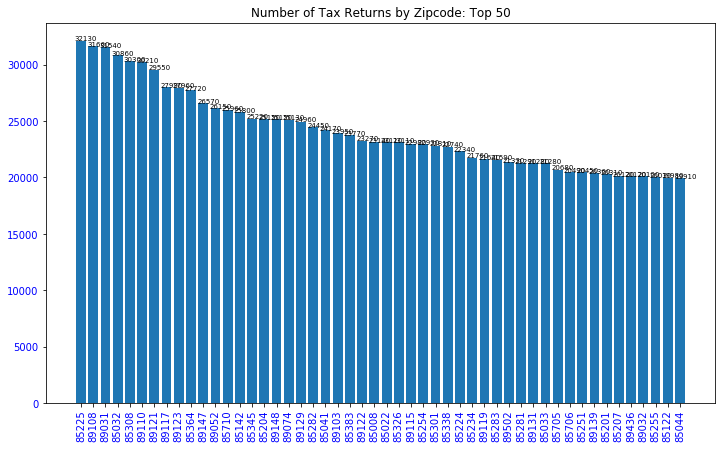

In [9]:
# This routine plots Top n zipcodes by size of Avg AGI

PltMX=pd.DataFrame(agi2016byzip['NoReturns'])
PltMX.index=agi2016byzip.index.get_level_values("ZIPCODE").astype(str)
PltMX=PltMX.sort_values('NoReturns', ascending=False)
PltToShow=50
PltTitle='Number of Tax Returns by Zipcode: Top ' + str(PltToShow)

print (PltTitle, ' ', PltMX.shape)
#print ('Date/time:', datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

#set PltMX (plot matrix) as input values; assumes input is in correct order
PltMX=PltMX.head(PltToShow)

#PltMX.columns = ['Count']
PltMX['Group']=PltMX.index #use index as plot label
PltMX['Label']=PltMX['Group']

#prep labels
bars=PltMX['Label']
y_pos = np.arange(len(bars))
height = PltMX['NoReturns'] #show 3 decimals if we are choosing the top 20

#bars
plt.bar(y_pos, height)


#xlabels, ylabels, title
plt.xticks(y_pos, bars, color='blue', rotation=90)
plt.yticks(color='blue')
plt.title(PltTitle)

# Text on the top of each barplot
for i in range(len(height)):
    plt.text(x = (i)-0.5 , y = height[i]+0.1, s = str(height[i]) , size = 7)
    
#width of display 
fig = plt.gcf()
fig.set_size_inches( 12, 7)

# Show graphic
plt.show()
